# Subtraction of close binaries
### Is there a binary and if so, what is its location?

In [210]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

import infofile as IF
import functionfile as FF

The star we use to subtract is the median of a selection all single stars we found in the YSES and WISPIT data. We sorted the stars from lowest to highest rms and made a median star each time with an extra star added until we found the median star with the lowest rms. 

In [211]:
with fits.open('med_star_all.fits') as hdul:
    sub = hdul[0].data

## 1. Import data and choose star
First we import the list of stars that have binaries close to their primary star. Next, we choose the star we want to look at.

In [212]:
raw_data = FF.star_data(IF.bin_c_names)
data = np.array([FF.data_reduction(raw_data[i]) for i in range(len(IF.bin_c_names))])

In [226]:
i = 0
star = data[i]

In [227]:
idx_stars_for_later = [1]

## 2. Find the main star
The next step is to identify the primary or main stars. In the case of these very close binaries, the telescope was not able to seperate them from each other so unlike for far away binaries, the center of the image is not on the primary star but in the middle of the two stars. To find the primary or main star, we search for the brightest pixel in an area of 100 pixels around the center of the image. 

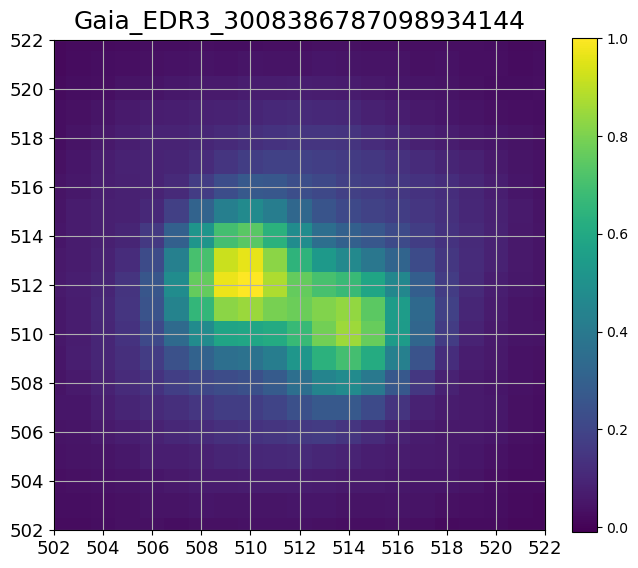

In [228]:
dx = 10 #Width/length of the image

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[i]}', fontsize = 18, y = 1.005)
plt.imshow(star, origin = 'lower')
plt.xticks(np.arange(512-dx, 512+dx+2, 2), fontsize = 13)
plt.yticks(np.arange(512-dx, 512+dx+2, 2), fontsize = 13)
plt.xlim(512-dx, 512+dx)
plt.ylim(512-dx, 512+dx)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()

In [216]:
def find_center(star, x, y, dx):
    ''' 
    Finds the brightest pixel in the image and returns this as the center of the star
    
    param star: 2d np.array containing the data of the star
    param x: x coordinate of the center of the area to be searched
    param y: y coordinate of the center of the area to be searched
    param dx: half the width/length you want to search
    
    returns: x and y position of the brightest pixel.
    '''
    
    idx_star = np.unravel_index(star[y-dx:y+dx, x-dx:x+dx].argmax(), star[y-dx:y+dx, x-dx:x+dx].shape)
    loc_x = idx_star[1] + x-dx
    loc_y = idx_star[0] + y-dx
    
    return loc_x, loc_y

In [217]:
#Position of the main star
p1 = find_center(star, 512, 512, 10)
print(f'The position of the main star is x = {p1[0]} and y = {p1[1]}.')

The position of the main star is x = 511 and y = 512.


## 3. Subtract median star from primary star
The next step is to subtract the median star we created earlier from the primary star. To do this we cut out an area of 100 pixels with at the center the primary star. Next we subtract the median star of this image. 

Because we cut out the star using a mask, the values of our pixels will change. Because we want to know the location of our stars in our original "coordinate system", we use the function make_ticks to change the labels at the axes of our figures. 

In [218]:
dx = 10 #half the width/length of the new image

In [219]:
def make_ticks(mid_x, mid_y, dx, step):
    ''' 
    Makes tick labels that correspond to the original pixel values
    
    param mid_x: x position of the center pixel
    param mid_y: y position of the center pixel
    param dx: half the width/length if the image
    
    return: a list with pixels values to be used as ticks.
    '''
    x = np.arange(mid_x-dx, mid_y+dx, step)
    ticks = []
    for i in range(len(x)):
        ticks.append(str(x[i]))
    return ticks

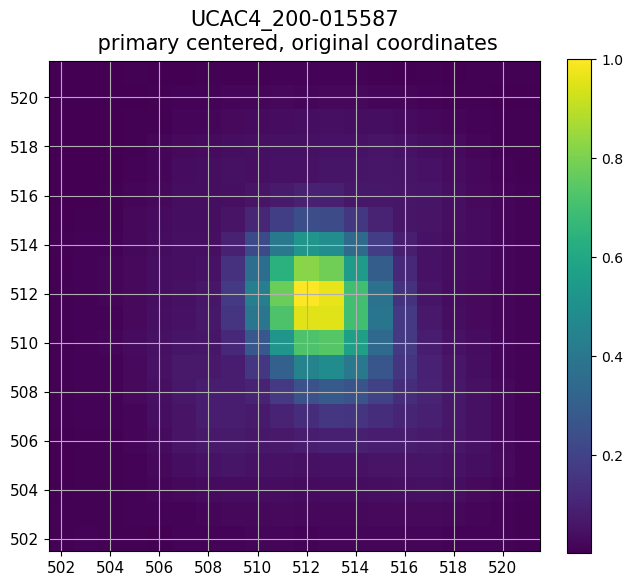

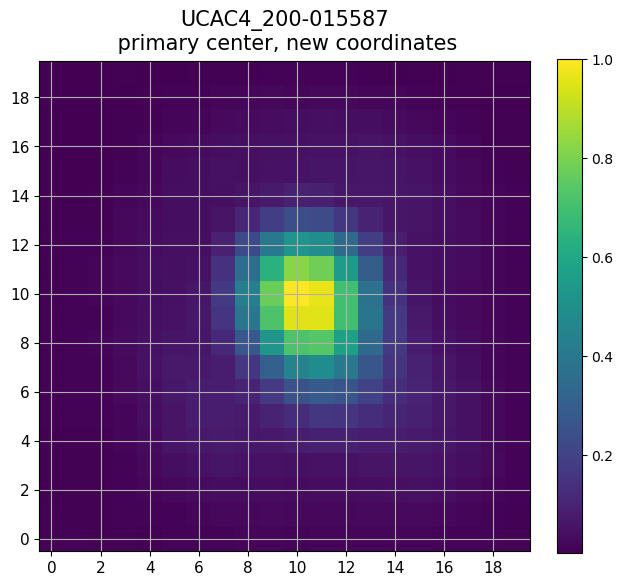

In [220]:
#We cut out and center the main star, still using the same coordinates in the figure
main = star[p1[1]-dx:p1[1]+dx, p1[0]-dx:p1[0]+dx]

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[i]}\n primary centered, original coordinates', fontsize = 15, y = 1.005)
plt.imshow(main, origin = 'lower')
plt.xticks(np.arange(0, 2*dx, 2), make_ticks(512, 512, dx, 2), fontsize = 11)
plt.yticks(np.arange(0, 2*dx, 2), make_ticks(512, 512, dx, 2), fontsize = 11)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[i]}\n primary center, new coordinates', fontsize = 15, y = 1.005)
plt.imshow(main, origin = 'lower')
plt.xticks(np.arange(0, 2*dx, 2), fontsize = 11)
plt.yticks(np.arange(0, 2*dx, 2), fontsize = 11)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()

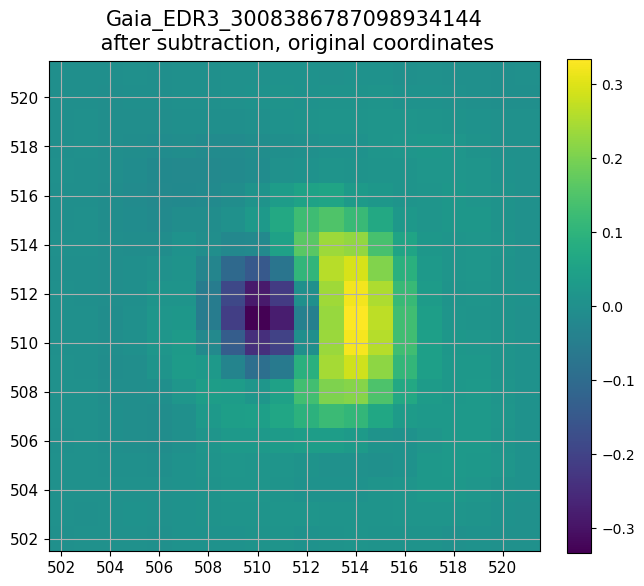

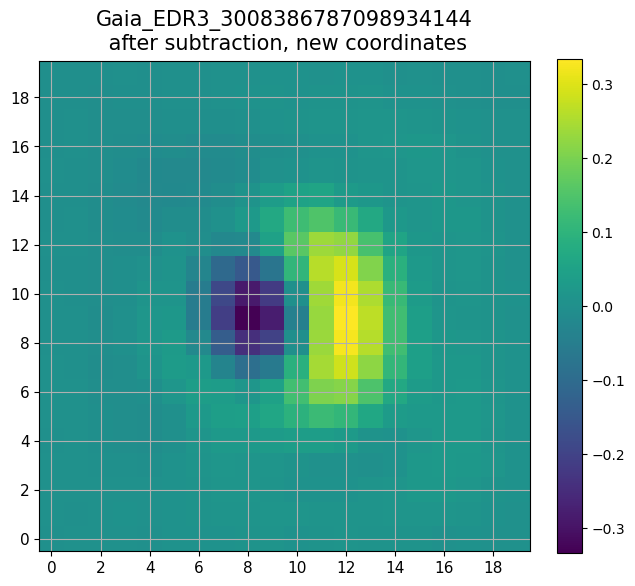

In [221]:
sub_cut = sub[512-dx:512+dx, 512-dx:512+dx]

rest = FF.subtract_star(main, sub_cut)

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[0]}\n after subtraction, original coordinates', fontsize = 15, y = 1.005)
plt.imshow(rest, origin = 'lower')
plt.xticks(np.arange(0, 2*dx, 2), make_ticks(512, 512, dx, 2), fontsize = 11)
plt.yticks(np.arange(0, 2*dx, 2), make_ticks(512, 512, dx, 2), fontsize = 11)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[0]}\n after subtraction, new coordinates', fontsize = 15, y = 1.005)
plt.imshow(rest, origin = 'lower')
plt.xticks(np.arange(0, 2*dx, 2), fontsize = 11)
plt.yticks(np.arange(0, 2*dx, 2), fontsize = 11)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()

## 4. Subtract median star from binary star
The next step is to subtract the median star from the binary star. Because we normalized the image using the primary star, we will have to scale the median star to match the brightness of the primary star. This scaling factor will be saved as the first guess for the relative brightness of the two binaries. The goal of this subtraction is to determine if we are in fact dealing with a binary and if so, to see if there is a hidden tertiary. 

In [222]:
p2 = find_center(rest, 9, 9, 5)
#p2 = (34, 29)

In [223]:
def og_coordinates(x, y, dx):
    '''
    Calculates the position of the star in the original coordinates
    
    param x: x position of the star in the new coordinates
    param y: y position of the star in the new coordinates
    param dx: half the size of the new image
    
    returns: x and y position in the original coordinates'''
    return x+512-dx, y+512-dx

In [224]:
print(f'The position of the binary is x = {og_coordinates(14, 8, 10)[0]}, y = {og_coordinates(14, 8, 10)[1]}.')

The position of the binary is x = 516, y = 510.


In [225]:
dx2 = 15

sec = rest[p2[1]-dx2:p2[1]+dx2, p2[0]-dx2:p2[0]+dx2]
sub_cut2 = sub[512-dx2:512+dx2, 512-dx2:512+dx2] * np.max(sec)

rest2 = FF.subtract_star(sec, sub_cut2)

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[i]}\n after subtraction of binary, original coordinates', fontsize = 15, y = 1.005)
plt.imshow(rest2, origin = 'lower')
plt.xticks(np.arange(0, 2*dx2, 2), make_ticks(512, 512, dx2, 2), fontsize = 11)
plt.yticks(np.arange(0, 2*dx2, 2), make_ticks(512, 512, dx2, 2), fontsize = 11)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()

plt.figure(figsize = (7, 7))
plt.title(f'{IF.bin_c_names[i]}\n after subtraction of binary, new coordinates', fontsize = 15, y = 1.005)
plt.imshow(rest2, origin = 'lower')
plt.xticks(np.arange(0, 2*dx2, 2), fontsize = 11)
plt.yticks(np.arange(0, 2*dx2, 2), fontsize = 11)
plt.colorbar(fraction = 0.0455)
plt.grid()
plt.show()
np.max(sec)

ValueError: operands could not be broadcast together with shapes (6,3) (30,30) 

In [ ]:
print(f'The relative brightness of the binary is {np.max(sec):.3f}.')